# Predicting the fuel efficiency of a car

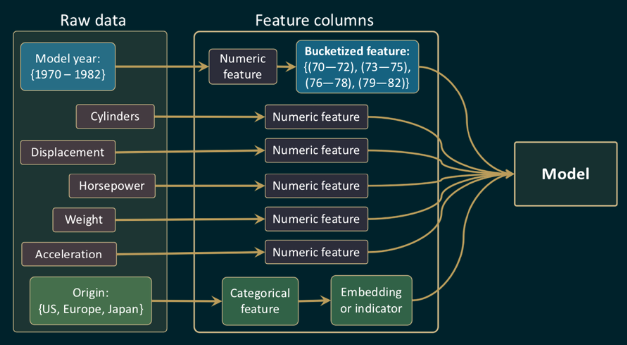

## Step 1: Preprocessing the data for traning

Step 1.1 download and view the data

In [22]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

import pandas as pd

columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
df = pd.read_csv(url, sep="\s+", header=None, names=columns)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Step 1.2 Remove null values

In [29]:
df = df.dropna()
df.horsepower = pd.to_numeric(df.horsepower, errors='coerce')
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

Step 1.3 convert categorical data to numerical

In [30]:
import torch
bounds = torch.tensor([73,76,79])

v = torch.tensor(df.model_year.values, dtype=torch.float32)
df['model_year_bucket'] = torch.bucketize(v, bounds,right=True)

Step 1.4 Normalize the data

In [40]:
x = df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year_bucket', 'origin']]

from matplotlib import axis
import torch

x_tensor = torch.tensor(x.values, dtype=torch.float32)
mean = x_tensor.mean(axis=0)
std = x_tensor.std(axis=0)

x_tensor = (x_tensor - mean) / std
y_tensor = torch.tensor(df.mpg.values, dtype=torch.float32)

pd.DataFrame(x_tensor.numpy())

,0,1,2,3,4,5,6
0,1.482053,1.075915,0.663285,0.619748,-1.283617,-1.446818,-0.715726
1,1.482053,1.486832,1.572585,0.842258,-1.464851,-1.446818,-0.715726
2,1.482053,1.181033,1.182885,0.539692,-1.646085,-1.446818,-0.715726
3,1.482053,1.047246,1.182885,0.536160,-1.283617,-1.446818,-0.715726
4,1.482053,1.028134,0.923085,0.554997,-1.827319,-1.446818,-0.715726
...,...,...,...,...,...,...,...
387,-0.862911,-0.519972,-0.479835,-0.220843,0.021268,1.236870,-0.715726
388,-0.862911,-0.930889,-1.363154,-0.997859,3.283480,1.236870,0.525711
389,-0.862911,-0.567753,-0.531795,-0.803605,-1.428604,1.236870,-0.715726
390,-0.862911,-0.711097,-0.661695,-0.415097,1.108672,1.236870,-0.715726


Step 1.5 Split data into train and test sets

In [43]:
train_size = int(len(x_tensor) * 0.8)
test_size = len(x_tensor) - train_size

x_train, x_test = x_tensor[:train_size], x_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([313, 7]),
 torch.Size([79, 7]),
 torch.Size([313]),
 torch.Size([79]))

## Step 2: Define the model architecture

In [44]:
model = torch.nn.Sequential(
    torch.nn.Linear(7, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model

Sequential(
  (0): Linear(in_features=7, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

## Step 3: Train the model

In [45]:
from torch.utils.data import DataLoader, TensorDataset
train_tensor = TensorDataset(x_train, y_train) 

for epoches in range(200):
    loss_hist_train = 0
    for x, y in DataLoader(train_tensor, batch_size=32):
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss
    
    if epoches % 10 == 0:
        print(f"epoch: {epoches} | loss: {loss_hist_train/len(train_tensor):.4f}")


/home/james/HDD/OneDrive/Cloud/tutorials/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/james/HDD/OneDrive/Cloud/tutorials/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 | loss: 9.3782
epoch: 10 | loss: 1.6314
epoch: 20 | loss: 1.6545
epoch: 30 | loss: 1.6124
epoch: 40 | loss: 1.5550
epoch: 50 | loss: 1.5042
epoch: 60 | loss: 1.4688
epoch: 70 | loss: 1.4361
epoch: 80 | loss: 1.4075
epoch: 90 | loss: 1.3874
epoch: 100 | loss: 1.3812
epoch: 110 | loss: 1.3765
epoch: 120 | loss: 1.3711
epoch: 130 | loss: 1.3648
epoch: 140 | loss: 1.3616
epoch: 150 | loss: 1.3588
epoch: 160 | loss: 1.3563
epoch: 170 | loss: 1.3539
epoch: 180 | loss: 1.3517
epoch: 190 | loss: 1.3496


## Step 4: Evaluate the model

In [47]:
with torch.no_grad():
    pred = model(x_test)
    loss = loss_fn(pred, y_test)
    print(f"loss: {loss}")

loss: 39.86767578125
